## Data Cleaning & EDA

In this notebook, we dive into the dataset itself and clean up many of the columns. There are a lot of identical exercises that are under slightly different names. Without accounting for this, our model would have a hard time understanding the relationship between all of the programs. We also run into a mess when looking at some of the programs, where some have over triple the amount of entries than they should have, forcing us to clean it up.

In [15]:
# import packages
import pandas as pd
import numpy as np
from thefuzz import fuzz, process
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
huge_data = pd.read_csv('../data/600k+ dataset/programs_detailed.csv')

In [4]:
# Convert date columns to Timestamp objects
huge_data['created'] = pd.to_datetime(huge_data['created'])
huge_data['last_edit'] = pd.to_datetime(huge_data['last_edit'])

# Convert level and goal columns from strings to lists
huge_data['level'] = huge_data['level'].apply(eval)
huge_data['goal'] = huge_data['goal'].apply(eval)

In [ ]:
# Drop all rows where there is no description, there are only 4 programs without one so this just makes it easier to work with.
# There is also one program that has NA values for nearly all important fields, it's not useful for analysis so we'll drop it.
# One workout just have last_edit column missing, just imputing it with the created column.

huge_data = (huge_data
             .dropna(axis=0, subset=['description', 'equipment'])
             .fillna(value={'last_edit': huge_data['created']})
             .reset_index().drop(columns=['index']))

In [6]:
# Convert all string/object columns in huge_data to lowercase
# Also choosing to not lower the description column, as sentiment information is lost when removing the case
str_cols = huge_data.select_dtypes(include='object').columns.drop(['level', 'goal', 'description'])
huge_data[str_cols] = huge_data[str_cols].apply(lambda x: x.str.lower())

for col in ['level', 'goal']:
    huge_data[col] = huge_data[col].apply(lambda lst: [s.lower() for s in lst])


In [7]:
exercise_sign = (
    huge_data[['exercise_name', 'reps']]
    .dropna(subset=['reps'])
    .query('reps != 0')
    .drop_duplicates(subset=['exercise_name'])
    .assign(sign=lambda d: np.sign(d['reps']))
    .set_index('exercise_name')['sign']
    .to_dict()
)

# Get unique exercise names
raw_exercises = huge_data['exercise_name'].dropna().unique()

# No cleaning – use raw names directly
exercise_to_raw = { ex: ex for ex in raw_exercises }
exercise_list = list(exercise_to_raw.keys())

threshold = 85
exercise_groups = {}

for ex in exercise_list:
    matches = process.extract(
        ex,
        exercise_list,
        scorer=fuzz.token_sort_ratio,
        limit=None
    )
    similar = [m[0] for m in matches if m[1] >= threshold]

    if similar:
        base = min(similar, key=len)
        base_raw = exercise_to_raw[base]

        if base_raw not in exercise_groups:
            exercise_groups[base_raw] = []
        variants = [exercise_to_raw[v] for v in similar]
        exercise_groups[base_raw].extend(variants)
        exercise_groups[base_raw] = list(set(exercise_groups[base_raw]))

grouped_rows = []
for base, variants in exercise_groups.items():
    # Collect signs for this group
    signs = [exercise_sign.get(v, 1) for v in variants]
    majority_sign = 1 if sum(signs) >= 0 else -1  # if there's a tie, just make it positive

    mask = huge_data['exercise_name'].isin(variants)
    huge_data.loc[mask, 'reps'] = huge_data.loc[mask, 'reps'].abs() * majority_sign

    grouped_rows.append({
        'grouped_exercise': base,
        'all_exercises': variants,
        'count': len(variants)
    })

grouped = pd.DataFrame(grouped_rows).sort_values('grouped_exercise').reset_index(drop=True)

In [8]:
# Map grouped exercise names back to the original dataframe
grouped_filtered = grouped[grouped['count'] > 1]

# Create a mapping from each variant to its grouped exercise name
variant_to_grouped = {}
for _, row in grouped_filtered.iterrows():
    base = row['grouped_exercise']
    for variant in row['all_exercises']:
        variant_to_grouped[variant] = base

# Apply the mapping in place to the exercise_name column
huge_data['exercise_name'] = huge_data['exercise_name'].map(variant_to_grouped).fillna(huge_data['exercise_name'])

There are some exercises that have messed up rep counts, for example in the workout program 'filling out the hoodie',

There are multiple exercises that have extraordinarily large rep counts. For example, we can look at the front squat (barbell) exercise:

In [9]:
huge_data[(huge_data['title'] == 'filling out the hoodie') & (huge_data['exercise_name'] == 'front squat (barbell)')].head(8)

,title,description,level,goal,equipment,program_length,time_per_workout,week,day,number_of_exercises,exercise_name,sets,reps,intensity,created,last_edit
292319,filling out the hoodie,The build strength and size,[advanced],[muscle & sculpting],full gym,8.0,90.0,1.0,2.0,5.0,front squat (barbell),3.0,9.0,8.0,2025-01-24 05:24:00,2025-06-18 08:34:00
292338,filling out the hoodie,The build strength and size,[advanced],[bodybuilding],full gym,8.0,90.0,1.0,5.0,5.0,front squat (barbell),6.0,12.0,8.0,2025-01-24 05:24:00,2025-06-18 08:34:00
292349,filling out the hoodie,The build strength and size,[advanced],[bodybuilding],full gym,8.0,90.0,2.0,2.0,5.0,front squat (barbell),3.0,12.0,7.0,2025-01-24 05:24:00,2025-06-18 08:34:00
292368,filling out the hoodie,The build strength and size,[advanced],[bodybuilding],full gym,8.0,90.0,2.0,5.0,5.0,front squat (barbell),6.0,10.0,7.0,2025-01-24 05:24:00,2025-06-18 08:34:00
292379,filling out the hoodie,The build strength and size,[advanced],[bodybuilding],full gym,8.0,90.0,3.0,2.0,5.0,front squat (barbell),3.0,86400.0,7.0,2025-01-24 05:24:00,2025-06-18 08:34:00
292398,filling out the hoodie,The build strength and size,[advanced],[bodybuilding],full gym,8.0,90.0,3.0,5.0,5.0,front squat (barbell),6.0,1800.0,7.0,2025-01-24 05:24:00,2025-06-18 08:34:00
292409,filling out the hoodie,The build strength and size,[advanced],[bodybuilding],full gym,8.0,90.0,4.0,2.0,5.0,front squat (barbell),3.0,600.0,8.0,2025-01-24 05:24:00,2025-06-18 08:34:00
292428,filling out the hoodie,The build strength and size,[advanced],[bodybuilding],full gym,8.0,90.0,4.0,5.0,5.0,front squat (barbell),6.0,60.0,8.0,2025-01-24 05:24:00,2025-06-18 08:34:00


Looking at the 'reps' column, we see that some exercises have rep counts for over 600, and one even being 86400! 

This obviously is corrupted data, and we can assume that it had something to do with the workout time the user inputted, as the large numbers are all factors of 60. There are 60 seconds in a minute, and seconds is the unit for the time based workouts. However, these exercises are not time-based, so it's a mystery to how this happened. 

For our case, we will reset out any rep sizes that are greater than 35 to the last known normal rep count for that program and exercise combo. If one cannot be found, we set the rep count to just be 10.

In [10]:
mask = huge_data['reps'] > 35

# Build a lookup table: (program, exercise) -> last valid rep count
lookup = (
    huge_data[~mask]
    .sort_index()
    .groupby(['title', 'exercise_name'])['reps']
    .last()
    .to_dict()
)

# Map each bad row to its replacement value
huge_data.loc[mask, 'reps'] = huge_data[mask].apply(
    lambda row: lookup.get((row['title'], row['exercise_name']), 10),
    axis=1
)

Looking at our example workout again:

In [11]:
huge_data[(huge_data['title'] == 'filling out the hoodie') & (huge_data['exercise_name'] == 'front squat (barbell)')].head(8)

,title,description,level,goal,equipment,program_length,time_per_workout,week,day,number_of_exercises,exercise_name,sets,reps,intensity,created,last_edit
292319,filling out the hoodie,The build strength and size,[advanced],[muscle & sculpting],full gym,8.0,90.0,1.0,2.0,5.0,front squat (barbell),3.0,9.0,8.0,2025-01-24 05:24:00,2025-06-18 08:34:00
292338,filling out the hoodie,The build strength and size,[advanced],[bodybuilding],full gym,8.0,90.0,1.0,5.0,5.0,front squat (barbell),6.0,12.0,8.0,2025-01-24 05:24:00,2025-06-18 08:34:00
292349,filling out the hoodie,The build strength and size,[advanced],[bodybuilding],full gym,8.0,90.0,2.0,2.0,5.0,front squat (barbell),3.0,12.0,7.0,2025-01-24 05:24:00,2025-06-18 08:34:00
292368,filling out the hoodie,The build strength and size,[advanced],[bodybuilding],full gym,8.0,90.0,2.0,5.0,5.0,front squat (barbell),6.0,10.0,7.0,2025-01-24 05:24:00,2025-06-18 08:34:00
292379,filling out the hoodie,The build strength and size,[advanced],[bodybuilding],full gym,8.0,90.0,3.0,2.0,5.0,front squat (barbell),3.0,10.0,7.0,2025-01-24 05:24:00,2025-06-18 08:34:00
292398,filling out the hoodie,The build strength and size,[advanced],[bodybuilding],full gym,8.0,90.0,3.0,5.0,5.0,front squat (barbell),6.0,10.0,7.0,2025-01-24 05:24:00,2025-06-18 08:34:00
292409,filling out the hoodie,The build strength and size,[advanced],[bodybuilding],full gym,8.0,90.0,4.0,2.0,5.0,front squat (barbell),3.0,10.0,8.0,2025-01-24 05:24:00,2025-06-18 08:34:00
292428,filling out the hoodie,The build strength and size,[advanced],[bodybuilding],full gym,8.0,90.0,4.0,5.0,5.0,front squat (barbell),6.0,10.0,8.0,2025-01-24 05:24:00,2025-06-18 08:34:00


There are multiple workouts that were inputted in a corrupted fashion. The original workout was showing many different options of how to workout based on  starting strength level, but every single one of those options was put into the dataset, causing a huge overload of webslinger workouts, which skewed many results. 

We will clean this up by just having the first entry per exercise per day per week of the program in the dataset.

One example of workout program that had this issue was 'webslinger'. You can view the original workout plan at: https://www.boostcamp.app/users/75sAks-webslinger-calisthenics.

In [12]:
def clean_duplicate_exercises(df, workout_name):
    """
    For a given workout, keep only the first occurrence of each exercise
    per day per week.
    """
    mask = df['title'] == workout_name
    workout_data = df[mask]

    # keep first occurrence of each exercise per day per week
    workout_clean = (workout_data
                     .sort_values(['week', 'day', 'exercise_name'])
                     .groupby(['week', 'day', 'exercise_name'], as_index=False)
                     .first())

    # replace the workout rows in the original dataframe
    return pd.concat([
        df[~mask],
        workout_clean
    ], ignore_index=True)

# Get unique workout titles
workout_titles = huge_data['title'].unique()

# Apply cleaning to every workout program
for workout in workout_titles:
    huge_data = clean_duplicate_exercises(huge_data, workout)

In [13]:
huge_data

,title,description,level,goal,equipment,program_length,time_per_workout,week,day,number_of_exercises,exercise_name,sets,reps,intensity,created,last_edit
0,weightlifting mobility program,This program is designed to help athletes succ...,"[beginner, novice, intermediate, advanced]","[olympic weightlifting, muscle & sculpting, bo...",garage gym,7.0,50.0,1.0,1.0,16.0,90/90 hip rotations,3.0,8.0,6.0,2025-03-09 04:11:00,2025-06-23 03:31:00
1,weightlifting mobility program,This program is designed to help athletes succ...,"[beginner, novice, intermediate, advanced]","[olympic weightlifting, muscle & sculpting, bo...",garage gym,7.0,50.0,1.0,1.0,16.0,banded ankle distractions,3.0,-18.0,6.0,2025-03-09 04:11:00,2025-06-23 03:31:00
2,weightlifting mobility program,This program is designed to help athletes succ...,"[beginner, novice, intermediate, advanced]","[olympic weightlifting, muscle & sculpting, bo...",garage gym,7.0,50.0,1.0,1.0,16.0,banded shoulder dislocates,3.0,10.0,6.0,2025-03-09 04:11:00,2025-06-23 03:31:00
3,weightlifting mobility program,This program is designed to help athletes succ...,"[beginner, novice, intermediate, advanced]","[olympic weightlifting, muscle & sculpting, bo...",garage gym,7.0,50.0,1.0,1.0,16.0,dead bug,3.0,-18.0,6.0,2025-03-09 04:11:00,2025-06-23 03:31:00
4,weightlifting mobility program,This program is designed to help athletes succ...,"[beginner, novice, intermediate, advanced]","[olympic weightlifting, muscle & sculpting, bo...",garage gym,7.0,50.0,1.0,1.0,16.0,hanging lat stretch,3.0,-18.0,6.0,2025-03-09 04:11:00,2025-06-23 03:31:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578279,matt vena modified,"Modofied version of Matt Vena program, with eq...",[intermediate],[powerbuilding],full gym,12.0,90.0,4.0,1.0,7.0,barbell squat,1.0,12.0,10.0,2024-09-07 07:27:00,2025-06-19 06:15:00
578280,matt vena modified,"Modofied version of Matt Vena program, with eq...",[intermediate],[powerbuilding],full gym,12.0,90.0,4.0,1.0,7.0,decline machine press,3.0,12.0,10.0,2024-09-07 07:27:00,2025-06-19 06:15:00
578281,matt vena modified,"Modofied version of Matt Vena program, with eq...",[intermediate],[powerbuilding],full gym,12.0,90.0,4.0,1.0,7.0,hammer curl,4.0,12.0,10.0,2024-09-07 07:27:00,2025-06-19 06:15:00
578282,matt vena modified,"Modofied version of Matt Vena program, with eq...",[intermediate],[powerbuilding],full gym,12.0,90.0,4.0,1.0,7.0,larsen press (barbell),3.0,12.0,10.0,2024-09-07 07:27:00,2025-06-19 06:15:00


## Exploring the Data

/var/folders/cj/mk6_35t16dg3wd3vjv0ymvw00000gn/T/ipykernel_24918/1612403717.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


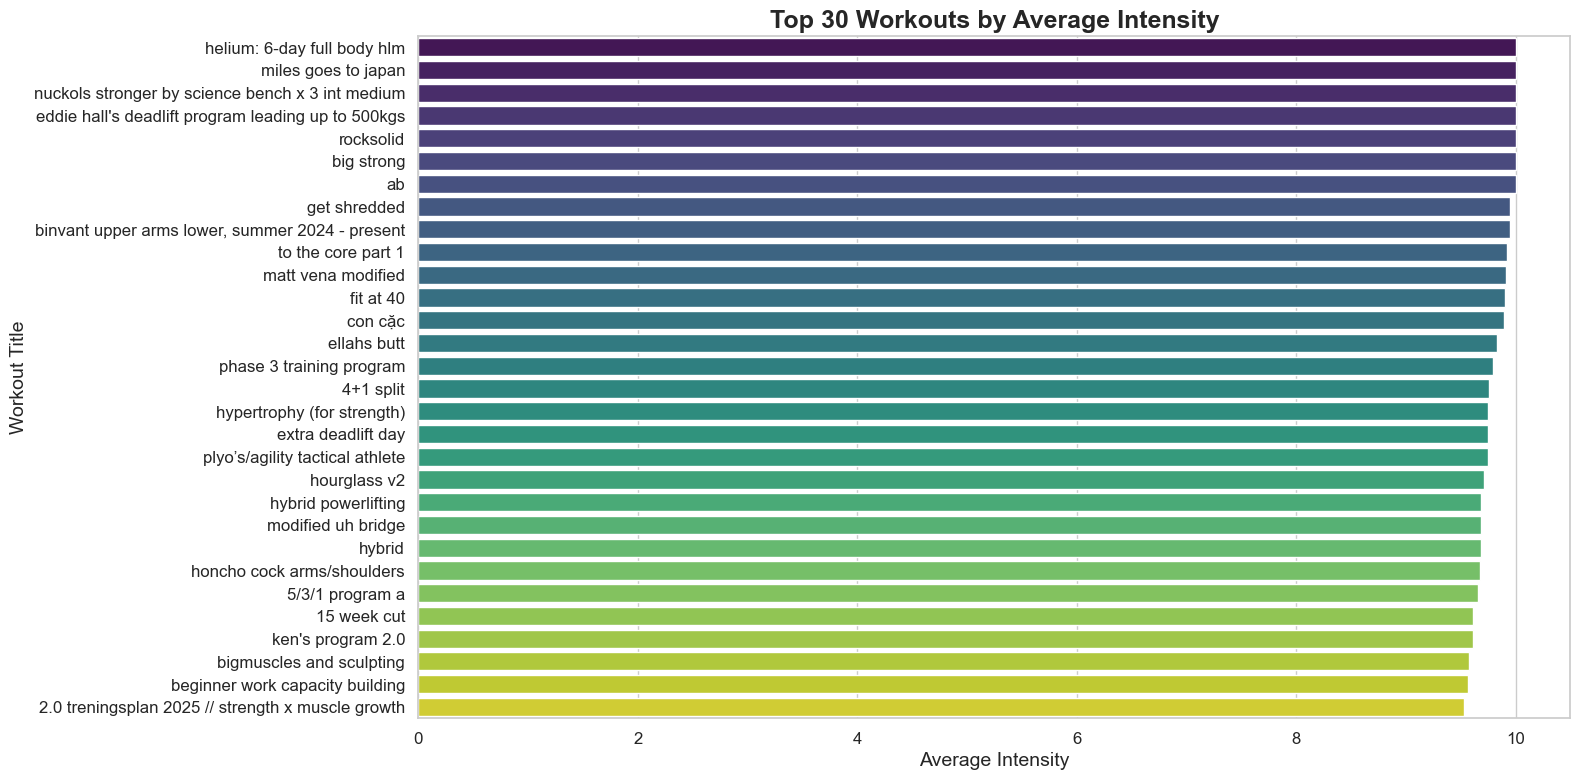

In [16]:
intensity_by_title = huge_data.groupby('title')['intensity'].mean().sort_values(ascending=False)

plt.figure(figsize=(16, 8))
sns.set(style="whitegrid", font_scale=1.1)

top_n = 30
sns.barplot(
    x=intensity_by_title.head(top_n).values,
    y=intensity_by_title.head(top_n).index,
    palette="viridis"
)

plt.title('Top 30 Workouts by Average Intensity', fontsize=18, weight='bold')
plt.xlabel('Average Intensity', fontsize=14)
plt.ylabel('Workout Title', fontsize=14)
plt.tight_layout()
plt.show()


Most workouts are have a very high average intensity. Most people on workout tracking apps are going to be serious about working out, so they'll work super hard in their programs. This will be something that we have to keep in the mind later in this project.

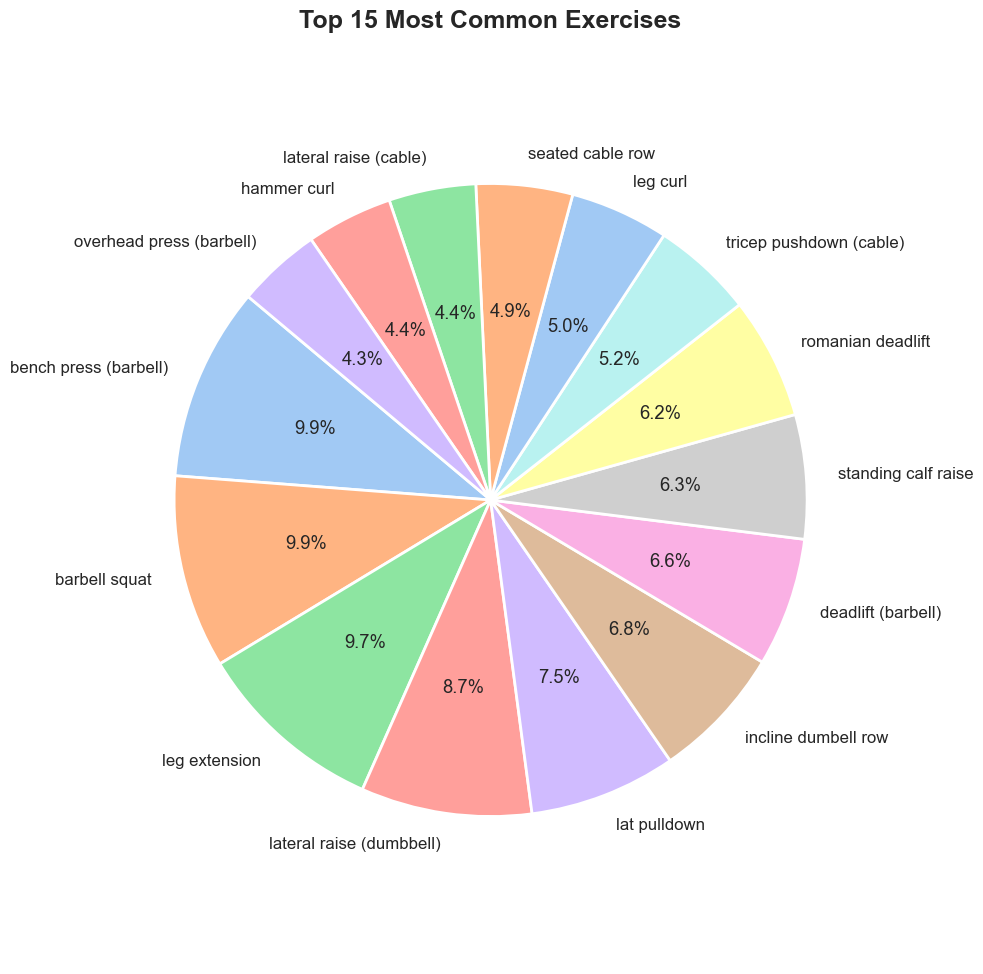

In [17]:
exercise_counts = huge_data['exercise_name'].value_counts().head(15)  

plt.figure(figsize=(10, 10))
colors = sns.color_palette('pastel')[0:len(exercise_counts)]

plt.pie(
    exercise_counts.values,
    labels=exercise_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops={'edgecolor': 'white', 'linewidth': 2}
)

plt.title('Top 15 Most Common Exercises', fontsize=18, weight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()


The top two most common exercises are unsurprisingly are the barbell bench press and barbell squat. Interestingly the leg extension is the third highest, showing that gym-goers actually do hit legs! Or, at least they plan on it...